<a href="https://colab.research.google.com/github/hasin-abrar/Machine-Learning/blob/master/CNN_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs        

In [ ]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0736
Epoch:2, Loss:0.0661
Epoch:3, Loss:0.0666
Epoch:4, Loss:0.0584
Epoch:5, Loss:0.0373
Epoch:6, Loss:0.0301
Epoch:7, Loss:0.0216
Epoch:8, Loss:0.0169
Epoch:9, Loss:0.0146
Epoch:10, Loss:0.0130
Epoch:11, Loss:0.0142
Epoch:12, Loss:0.0116
Epoch:13, Loss:0.0099
Epoch:14, Loss:0.0099
Epoch:15, Loss:0.0084
Epoch:16, Loss:0.0088
Epoch:17, Loss:0.0073
Epoch:18, Loss:0.0072
Epoch:19, Loss:0.0071
Epoch:20, Loss:0.0068


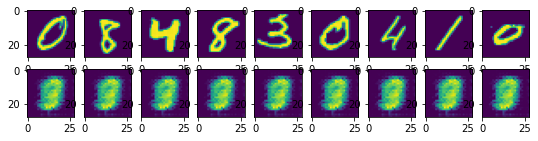

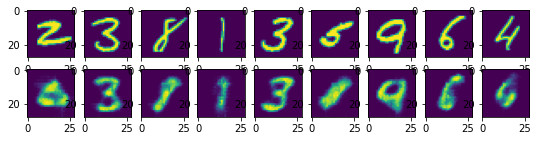

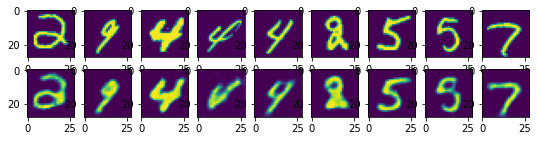

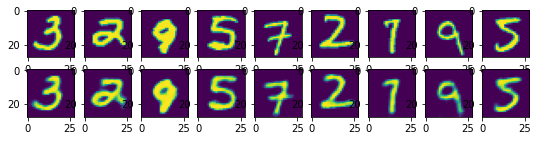

In [ ]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

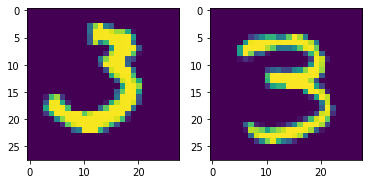

In [ ]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

In [ ]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

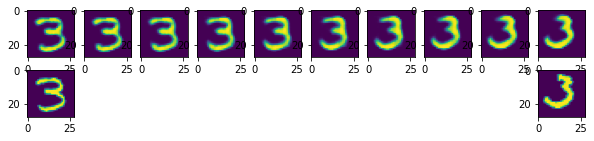

In [ ]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

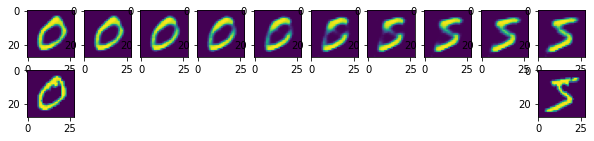

In [ ]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

interpolate(0, 1)

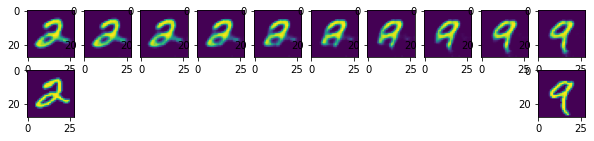

In [ ]:
interpolate(4, 5)